# Playing with the integration layer

When the command `docker-compose up builder` finishes its execution, you'll find the following files in this folder:

- character.parquet
- dialogue.parquet
- episode.parquet
- scene.parquet

We can use them to analyze all the data and answer some questions, such as which character has more lines?

## Playing with DataFrames

Giving you have executed the command mentioned above, now we can create the DataFrames from the parquet files:

In [1]:
import pandas as pd

dialogue_df = pd.read_parquet("dialogue.parquet")
episode_df = pd.read_parquet(f"episode.parquet")
dialogue_df = pd.read_parquet(f"dialogue.parquet")
character_df = pd.read_parquet(f"character.parquet")
scene_df = pd.read_parquet(f"scene.parquet")

Now that we have all DFs, let's see the main characters:

In [2]:
character_df_only_main = character_df.query("IS_MAIN == True")

character_df_only_main

,NAME,IS_MAIN
0,ROSS,True
1,MONICA,True
2,PHOEBE,True
3,RACHEL,True
4,CHANDLER,True
5,JOEY,True


You can navigate through the DataFrame selecting a slice of it! See the example below:

In [3]:
page = 0
items_per_page = 20
where_to_start = (page * 1) * items_per_page
where_to_finish = where_to_start + items_per_page

character_df.iloc[where_to_start:where_to_finish,:].head(items_per_page)

,NAME,IS_MAIN
0,ROSS,True
1,MONICA,True
2,PHOEBE,True
3,RACHEL,True
4,CHANDLER,True
5,JOEY,True
6,MONICA AND PHOEBE,False
7,MELANIE,False
8,FLIGHT ATTENDANT,False
9,MAN,False


How about which is the character that has more lines on the show? 📣

<AxesSubplot:xlabel='CHARACTER_NAME'>

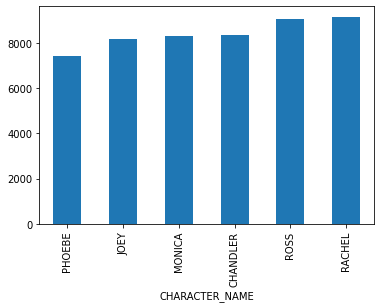

In [4]:
# INNER JOIN to configure a DF only with dialogues from main characters
dialogue_df_only_with_main_characters = pd.merge(dialogue_df, character_df_only_main, left_on='CHARACTER_NAME',right_on='NAME')

final_df = dialogue_df_only_with_main_characters.groupby(["CHARACTER_NAME"])["SEASON_NUMBER"].count().sort_values()
final_df.plot(kind="bar", x="CHARACTER_NAME")

What about the number of lines per season by each main character? 📜

In [5]:
final_df = dialogue_df_only_with_main_characters.groupby(["CHARACTER_NAME", "SEASON_NUMBER"])["SEASON_NUMBER"].count().unstack()

final_df

SEASON_NUMBER,1,2,3,4,5,6,7,8,9,10
CHARACTER_NAME,,,,,,,,,,
CHANDLER,817,712,825,912,941,1035,847,673,925,687
JOEY,640,656,775,815,932,907,930,904,875,730
MONICA,872,703,847,766,898,899,899,812,911,683
PHOEBE,637,610,793,711,813,787,800,771,805,689
RACHEL,850,733,925,908,906,991,1092,1083,907,769
ROSS,951,869,1075,807,870,911,821,979,899,863


<AxesSubplot:xlabel='CHARACTER_NAME'>

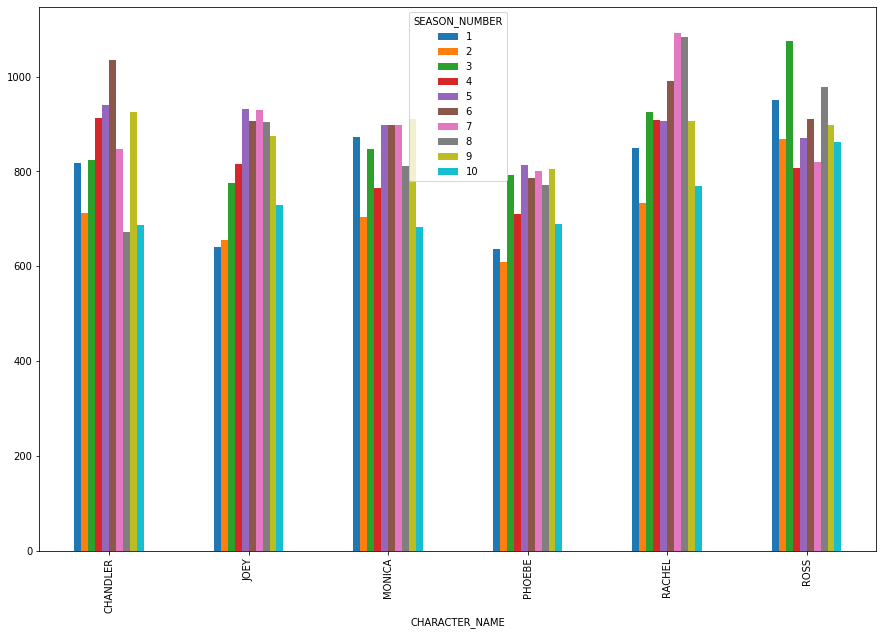

In [6]:
final_df.plot(kind='bar', figsize=(15, 10))

## Playing with the database

You can play with the following tables:

![RabbitMQ Dashboard](../../docs/integration-layer-entities.png)

First let us configure the connection that we'll use during our queries:

In [7]:
from module_path_resolution import add_custom_module_path
# So we can import modules including the project folder
add_custom_module_path()
# Know what we're going to use indeed!
from pyfriends.database_utils import retrieve_engine

# # This is required so to_sql can work properly with postgresql
engine = retrieve_engine()

How is the number of scenes by season/episode?

In [8]:
raw_dql = """
    SELECT sea.number "SEASON", ep.number "EPISODE", COUNT(*) "COUNT OF SCENES"
    FROM episode ep
             INNER JOIN season sea on sea.id = ep.season_id
             INNER JOIN scene sce on ep.id = sce.episode_id
    GROUP BY sea.number, ep.number
    ORDER BY sea.number, ep.number;
"""

pd.read_sql(raw_dql, engine)

,SEASON,EPISODE,COUNT OF SCENES
0,1,01,15
1,1,02,11
2,1,03,14
3,1,04,16
4,1,05,16
...,...,...,...
222,10,13,13
223,10,14,13
224,10,15,13
225,10,16,14
